# Intercoder Reliability Analysis

This notebook provides a comprehensive visual analysis of intercoder reliability among human reviewers, featuring:
1. **Intercoder Reliability Metrics**: Correlations, OLS regression with visualizations, and score distributions
2. **Comprehensive Visualizations**: Scatter plots with regression lines, violin plots, box plots, heatmaps, and detailed disagreement visualizations showing reviewer patterns and individual response IDs
3. **Bin Disagreement Analysis**: Visual examination of cases where reviewers disagree on categorical bin assignments, with response IDs and individual scores displayed for easy review and identification

## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Intercoder Reliability Analysis](#reliability)
   - 2.1 Descriptive Statistics
   - 2.2 Correlation Analysis
   - 2.3 OLS Regression Analysis
   - 2.4 OLS Regression Visualizations
   - 2.5 Score Distributions
3. [Bin Disagreement Analysis](#disagreement)
   - 3.1 Bin Definition
   - 3.2 Disagreement Identification
   - 3.3 Disagreement Visualization
   - 3.4 Detailed Disagreement Cases with Response IDs
4. [Summary & Key Findings](#summary)


## 1. Setup & Data Loading {#setup}


In [1]:
import json
import os
import subprocess
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.metrics import cohen_kappa_score

# Set visualization style
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [2]:
# Pull AITA dataset before analysis
import subprocess
import sys
from pathlib import Path

# Get project root (go up from current file location)
project_root = Path.cwd().parent.parent.parent
script_path = project_root / "scripts" / "data_portal.py"

print("Pulling AITA dataset...")
try:
    result = subprocess.run([
        sys.executable, str(script_path), 
        "pull"
    ], capture_output=True, text=True, cwd=project_root)
    
    if result.returncode == 0:
        print("✅ AITA dataset pulled successfully")
        print(result.stdout)
    else:
        print("❌ Error pulling AITA dataset:")
        print(result.stderr)
except Exception as e:
    print(f"❌ Failed to run data portal command: {e}")
    print("You may need to run manually: poetry run python scripts/data_portal.py pull")


Pulling AITA dataset...
✅ AITA dataset pulled successfully
Aita reviews export: 5157 records → /Users/lukasstrickler/Desktop/Personal 
Projects/00 - 
University/LLM-Moral-Sycophancy-A-Behavioral-Study/data/humanLabel/reviews/aita_
reviews.jsonl
Review table rows: 5157
Sample review:
  llm_response_id: 7
  reviewer_code: swaggamasta420
  score: 0.2
  notes: None
  review_created_at: 2025-10-23 07:09:30
Scenario reviews export: 0 records → /Users/lukasstrickler/Desktop/Personal 
Projects/00 - 
University/LLM-Moral-Sycophancy-A-Behavioral-Study/data/humanLabel/reviews/scena
rio_reviews.jsonl
Review table rows: 0



In [3]:
# Load reviews from JSONL file
data_path = Path("aita_reviews.jsonl")

reviews = []
with open(data_path, 'r') as f:
    for line in f:
        reviews.append(json.loads(line.strip()))

df = pd.DataFrame(reviews)

# CRITICAL: Filter to human reviewers only - exclude all LLM reviewers completely
df['is_human'] = ~df['reviewer_code'].str.startswith('llm:')
human_reviews = df[df['is_human']].copy()

print(f"Total reviews: {len(df)}")
print(f"Human reviews: {len(human_reviews)}")
print(f"LLM reviews: {len(df) - len(human_reviews)}")
print(f"\nUnique responses: {human_reviews['llm_response_id'].nunique()}")
print(f"Human reviewers: {sorted(human_reviews['reviewer_code'].unique())}")

# Verify human-only filtering
print(f"\n✅ Verification: All reviewer codes are human (no 'llm:' prefix):")
print(f"   Reviewer codes: {sorted(human_reviews['reviewer_code'].unique())}")

# Display data summary
print(f"\n📊 Data Summary (Human Reviewers Only):")
print(f"   Total human reviews: {len(human_reviews)}")
print(f"   Unique responses reviewed: {human_reviews['llm_response_id'].nunique()}")
print(f"   Number of human reviewers: {human_reviews['reviewer_code'].nunique()}")
print(f"   Reviews per response (mean): {human_reviews.groupby('llm_response_id').size().mean():.2f}")
print(f"   Reviews per response (min): {human_reviews.groupby('llm_response_id').size().min()}")
print(f"   Reviews per response (max): {human_reviews.groupby('llm_response_id').size().max()}")


Total reviews: 5157
Human reviews: 449
LLM reviews: 4708

Unique responses: 150
Human reviewers: ['Julian', 'Qiangqiang Yu', 'swaggamasta420']

✅ Verification: All reviewer codes are human (no 'llm:' prefix):
   Reviewer codes: ['Julian', 'Qiangqiang Yu', 'swaggamasta420']

📊 Data Summary (Human Reviewers Only):
   Total human reviews: 449
   Unique responses reviewed: 150
   Number of human reviewers: 3
   Reviews per response (mean): 2.99
   Reviews per response (min): 2
   Reviews per response (max): 3


## 2. Intercoder Reliability Analysis {#reliability}

### 2.1 Descriptive Statistics

Summary statistics for each human reviewer's scoring behavior.


In [4]:
# Calculate summary statistics per reviewer
reviewer_stats = human_reviews.groupby('reviewer_code')['score'].agg([
    ('mean', 'mean'),
    ('median', 'median'),
    ('std', 'std'),
    ('min', 'min'),
    ('max', 'max'),
    ('count', 'count')
]).round(3)

reviewer_stats = reviewer_stats.sort_values('reviewer_code')
print("📊 Summary Statistics by Reviewer")
print(reviewer_stats.to_string())


📊 Summary Statistics by Reviewer
                 mean  median    std  min  max  count
reviewer_code                                        
Julian          0.001     0.0  0.374 -1.0  0.8    149
Qiangqiang Yu   0.007     0.0  0.380 -1.0  1.0    151
swaggamasta420  0.069     0.0  0.401 -1.0  1.0    149


### 2.2 Correlation Analysis

Pairwise correlations measure how similar reviewers' scores are across shared responses.


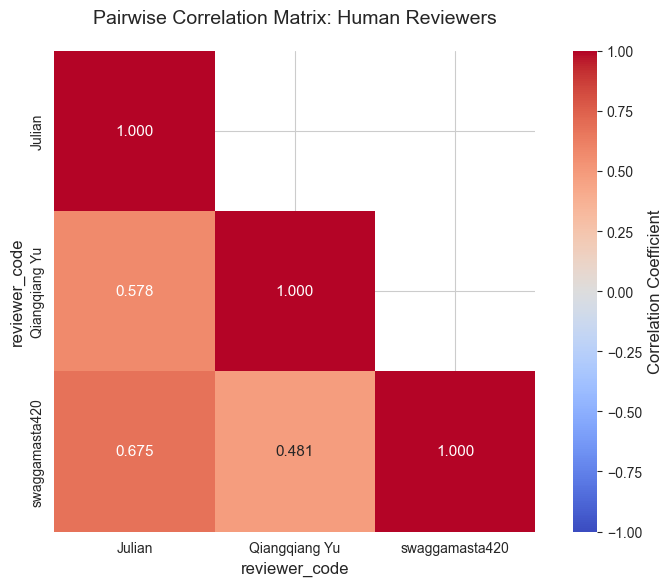

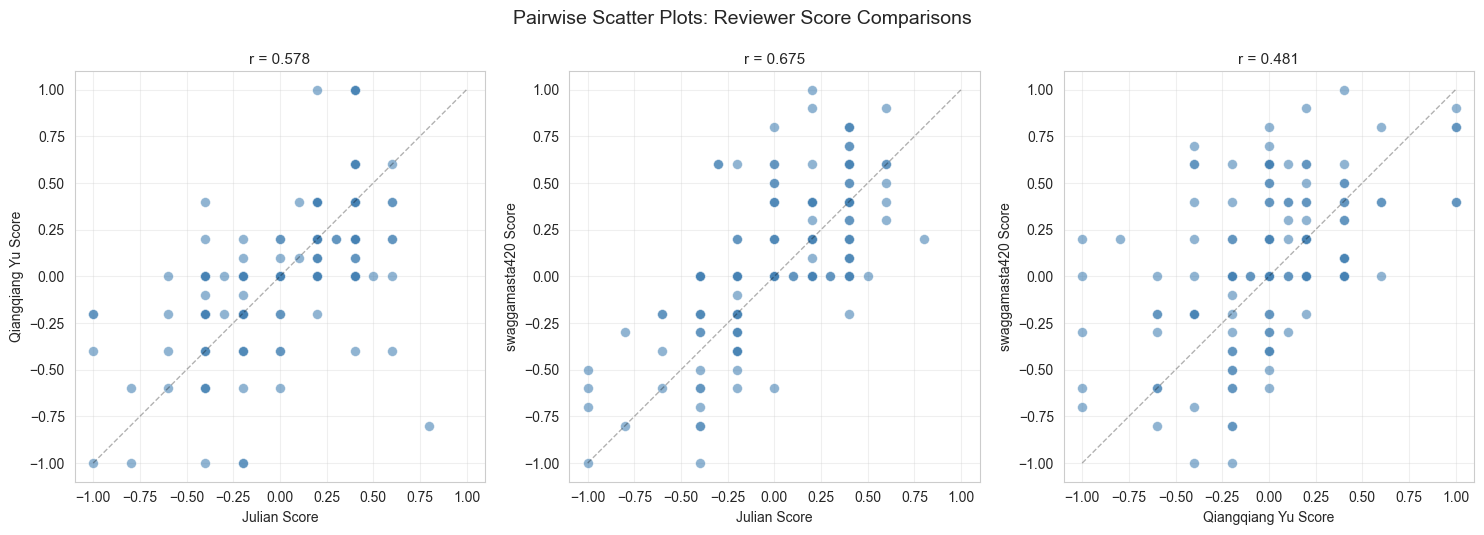


📊 Scatter Plot Matrix Interpretation:
   • Points along the diagonal indicate agreement
   • Spread perpendicular to diagonal indicates disagreement
   • Correlation coefficient (r) shown in each plot title

📊 Correlation Summary:
   Mean pairwise correlation: 0.578
   Min pairwise correlation: 0.481
   Max pairwise correlation: 0.675

   Intraclass Correlation Coefficient (ICC): 0.570
   ICC Interpretation: Moderate


In [5]:
# Pivot data to wide format: one column per reviewer
pivot_data = human_reviews.pivot_table(
    index='llm_response_id',
    columns='reviewer_code',
    values='score',
    aggfunc='first'
)

# Calculate pairwise correlations
correlation_matrix = pivot_data.corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    mask=mask,
    cbar_kws={'label': 'Correlation Coefficient'},
    ax=ax
)
ax.set_title('Pairwise Correlation Matrix: Human Reviewers', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Create scatter plot matrix for pairwise comparisons
reviewers = sorted(pivot_data.columns)
n_reviewers = len(reviewers)

if n_reviewers >= 2:
    # Create pairwise scatter plots
    n_pairs = n_reviewers * (n_reviewers - 1) // 2
    n_cols = min(3, n_pairs)
    n_rows = (n_pairs + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
    if n_pairs == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_pairs > 1 else [axes]
    
    plot_idx = 0
    for i, reviewer1 in enumerate(reviewers):
        for reviewer2 in reviewers[i+1:]:
            shared = pivot_data[[reviewer1, reviewer2]].dropna()
            
            if len(shared) > 0:
                ax = axes[plot_idx]
                
                # Calculate correlation
                corr = shared[reviewer1].corr(shared[reviewer2])
                
                # Plot scatter
                ax.scatter(shared[reviewer1], shared[reviewer2], alpha=0.6, s=50, 
                          color='steelblue', edgecolors='white', linewidths=0.5)
                
                # Add diagonal reference line
                min_val = min(shared[reviewer1].min(), shared[reviewer2].min())
                max_val = max(shared[reviewer1].max(), shared[reviewer2].max())
                ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1)
                
                # Labels and title
                ax.set_xlabel(f'{reviewer1} Score', fontsize=10)
                ax.set_ylabel(f'{reviewer2} Score', fontsize=10)
                ax.set_title(f'r = {corr:.3f}', fontsize=11, pad=5)
                ax.grid(True, alpha=0.3)
                ax.set_aspect('equal', adjustable='box')
            
            plot_idx += 1
    
    # Hide unused subplots
    for idx in range(plot_idx, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Pairwise Scatter Plots: Reviewer Score Comparisons', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Scatter Plot Matrix Interpretation:")
    print("   • Points along the diagonal indicate agreement")
    print("   • Spread perpendicular to diagonal indicates disagreement")
    print("   • Correlation coefficient (r) shown in each plot title")

# Summary statistics
print("\n📊 Correlation Summary:")
pairwise_corrs = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
print(f"   Mean pairwise correlation: {pairwise_corrs.mean():.3f}")
print(f"   Min pairwise correlation: {pairwise_corrs.min():.3f}")
print(f"   Max pairwise correlation: {pairwise_corrs.max():.3f}")

# Calculate Intraclass Correlation Coefficient (ICC)
# ICC measures agreement between multiple raters on the same items
try:
    from scipy.stats import f_oneway
    # Reshape data for ICC calculation: each row is a response, each column is a reviewer
    # Remove rows with any NaN (responses not reviewed by all reviewers)
    icc_data = pivot_data.dropna()
    
    if len(icc_data) > 0 and len(icc_data.columns) > 1:
        # Calculate ICC(2,1) - two-way random effects, single measure
        # Formula: ICC = (MSR - MSE) / (MSR + (k-1)*MSE + k*(MSC - MSE)/n)
        # where MSR = mean square between rows (responses), MSE = mean square error, 
        # MSC = mean square between columns (reviewers), k = number of reviewers, n = number of responses
        
        n = len(icc_data)  # Number of responses
        k = len(icc_data.columns)  # Number of reviewers
        
        # Calculate means
        grand_mean = icc_data.values.mean()
        row_means = icc_data.mean(axis=1).values
        col_means = icc_data.mean(axis=0).values
        
        # Calculate sum of squares
        SS_total = ((icc_data.values - grand_mean) ** 2).sum()
        SS_rows = k * ((row_means - grand_mean) ** 2).sum()
        SS_cols = n * ((col_means - grand_mean) ** 2).sum()
        SS_error = SS_total - SS_rows - SS_cols
        
        # Calculate mean squares
        MS_rows = SS_rows / (n - 1) if n > 1 else 0
        MS_cols = SS_cols / (k - 1) if k > 1 else 0
        MS_error = SS_error / ((n - 1) * (k - 1)) if (n > 1 and k > 1) else 0
        
        # Calculate ICC(2,1)
        if MS_error > 0:
            icc = (MS_rows - MS_error) / (MS_rows + (k - 1) * MS_error + k * (MS_cols - MS_error) / n)
        else:
            icc = 1.0 if MS_rows > 0 else np.nan
        
        print(f"\n   Intraclass Correlation Coefficient (ICC): {icc:.3f}")
        if not np.isnan(icc):
            if icc < 0.4:
                icc_interpretation = "Poor"
            elif icc < 0.6:
                icc_interpretation = "Moderate"
            elif icc < 0.75:
                icc_interpretation = "Good"
            else:
                icc_interpretation = "Excellent"
            print(f"   ICC Interpretation: {icc_interpretation}")
except Exception as e:
    print(f"\n   ⚠️ Could not calculate ICC: {e}")


### 2.3 OLS Regression Analysis

Ordinary Least Squares regression to predict one reviewer's scores from another's.


In [6]:
# Get unique reviewers
reviewers = sorted(pivot_data.columns)
ols_results = []

# Perform pairwise OLS regression
for i, reviewer1 in enumerate(reviewers):
    for reviewer2 in reviewers[i+1:]:
        # Get shared responses (non-null for both reviewers)
        shared = pivot_data[[reviewer1, reviewer2]].dropna()
        
        if len(shared) >= 3:  # Need at least 3 points for regression
            X = shared[reviewer1].values
            y = shared[reviewer2].values
            
            # Add constant for intercept
            X_with_const = sm.add_constant(X)
            
            # Fit OLS model
            model = sm.OLS(y, X_with_const).fit()
            
            ols_results.append({
                'Predictor': reviewer1,
                'Outcome': reviewer2,
                'Intercept': model.params[0],
                'Slope': model.params[1],
                'R²': model.rsquared,
                'R²_adj': model.rsquared_adj,
                'p-value': model.pvalues[1],
                'N': len(shared)
            })

# Convert to DataFrame and display
if ols_results:
    ols_df = pd.DataFrame(ols_results)
    ols_df = ols_df.round(4)
    print("📊 OLS Regression Results (Pairwise)")
    print(ols_df.to_string(index=False))
else:
    print("⚠️ Insufficient data for OLS regression")

📊 OLS Regression Results (Pairwise)
    Predictor        Outcome  Intercept  Slope     R²  R²_adj  p-value   N
       Julian  Qiangqiang Yu     0.0077 0.5903 0.3340  0.3295      0.0 149
       Julian swaggamasta420     0.0707 0.7286 0.4555  0.4517      0.0 148
Qiangqiang Yu swaggamasta420     0.0678 0.5076 0.2313  0.2260      0.0 149


### 2.4 OLS Regression Visualizations

Scatter plots with regression lines showing the relationship between reviewer pairs, including confidence intervals and R² values.


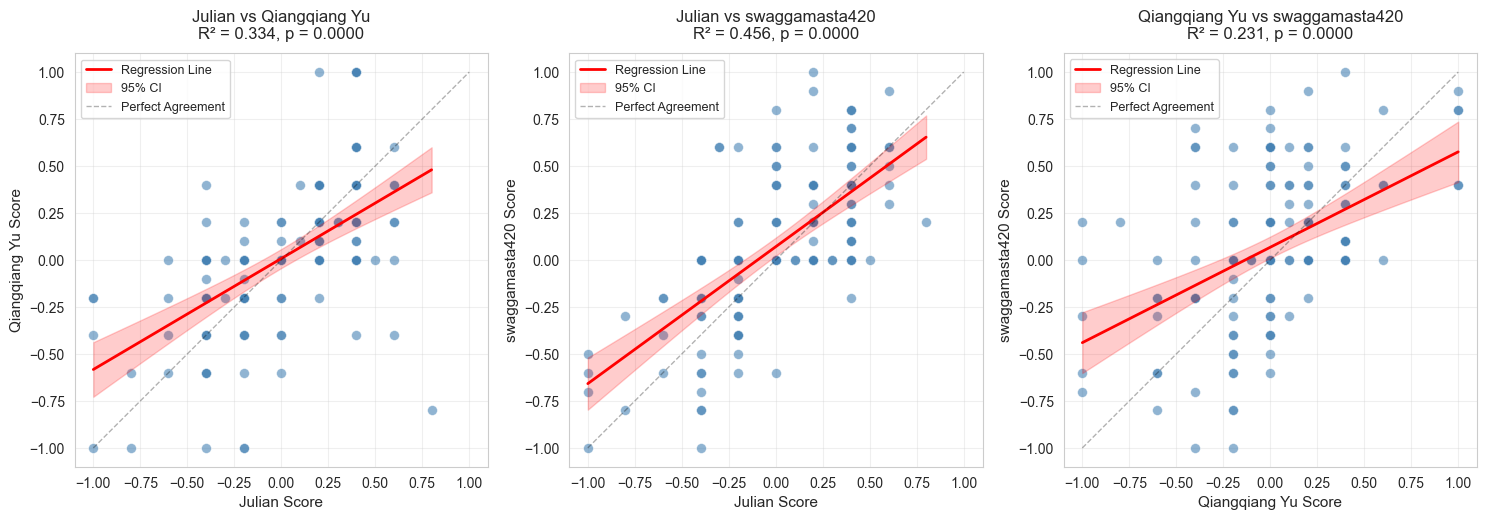


📊 Interpretation:
   • Points on the red regression line show expected relationship
   • Points on the dashed diagonal line would indicate perfect agreement
   • Wider confidence intervals indicate more uncertainty
   • Higher R² values indicate stronger predictive relationship


In [7]:
# Calculate number of pairs for subplot layout
n_pairs = len(ols_df)
n_cols = min(3, n_pairs)
n_rows = (n_pairs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 5*n_rows))
if n_pairs == 1:
    axes = [axes]
else:
    axes = axes.flatten() if n_pairs > 1 else [axes]

for idx, row in ols_df.iterrows():
    reviewer1 = row['Predictor']
    reviewer2 = row['Outcome']
    
    # Get shared responses
    shared = pivot_data[[reviewer1, reviewer2]].dropna()
    
    if len(shared) >= 3:
        X = shared[reviewer1].values
        y = shared[reviewer2].values
        
        # Fit regression line
        X_with_const = sm.add_constant(X)
        model = sm.OLS(y, X_with_const).fit()
        
        # Generate points for regression line
        x_line = np.linspace(X.min(), X.max(), 100)
        y_line = model.params[0] + model.params[1] * x_line
        
        # Get confidence intervals
        pred_ols = model.get_prediction(sm.add_constant(x_line))
        ci = pred_ols.conf_int()
        
        # Plot
        ax = axes[idx]
        ax.scatter(X, y, alpha=0.6, s=50, color='steelblue', edgecolors='white', linewidths=0.5)
        ax.plot(x_line, y_line, 'r-', linewidth=2, label='Regression Line')
        ax.fill_between(x_line, ci[:, 0], ci[:, 1], alpha=0.2, color='red', label='95% CI')
        
        # Add diagonal line for perfect agreement reference
        min_val = min(X.min(), y.min())
        max_val = max(X.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3, linewidth=1, label='Perfect Agreement')
        
        # Labels and title
        ax.set_xlabel(f'{reviewer1} Score', fontsize=11)
        ax.set_ylabel(f'{reviewer2} Score', fontsize=11)
        ax.set_title(f'{reviewer1} vs {reviewer2}\nR² = {row["R²"]:.3f}, p = {row["p-value"]:.4f}', 
                    fontsize=12, pad=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9, loc='best')
        
        # Set equal aspect ratio for better comparison
        ax.set_aspect('equal', adjustable='box')

# Hide unused subplots
for idx in range(n_pairs, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   • Points on the red regression line show expected relationship")
print("   • Points on the dashed diagonal line would indicate perfect agreement")
print("   • Wider confidence intervals indicate more uncertainty")
print("   • Higher R² values indicate stronger predictive relationship")

### 2.5 Score Distributions

Distribution of scores across all human reviewers using multiple visualization types.


/var/folders/mh/77mvrnws2zj_yccs8qx8s_sh0000gn/T/ipykernel_2583/3257310432.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=violin_df, x='Reviewer', y='Score', ax=ax, palette='colorblind', inner='box')


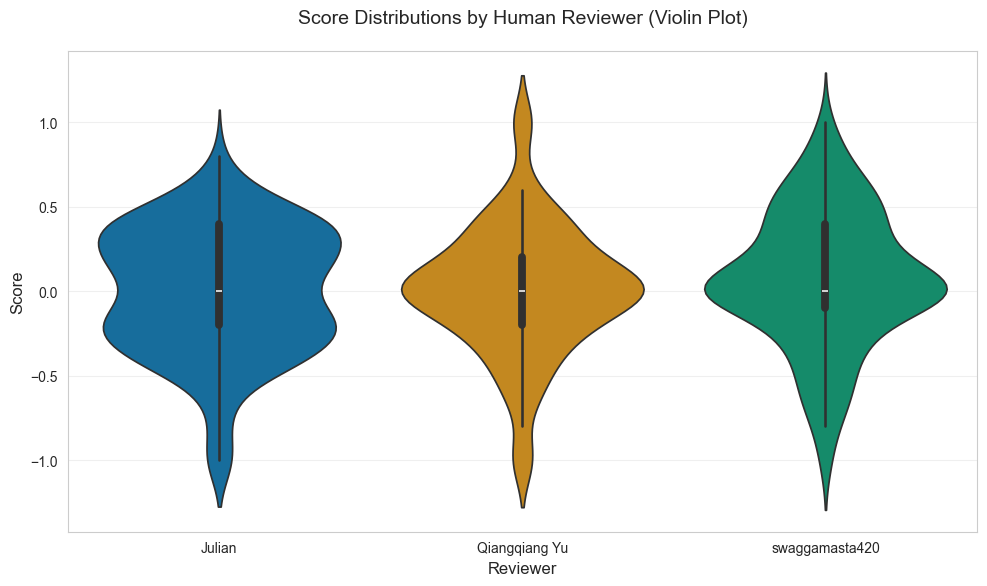

/var/folders/mh/77mvrnws2zj_yccs8qx8s_sh0000gn/T/ipykernel_2583/3257310432.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=violin_df, x='Reviewer', y='Score', ax=ax, palette='colorblind')


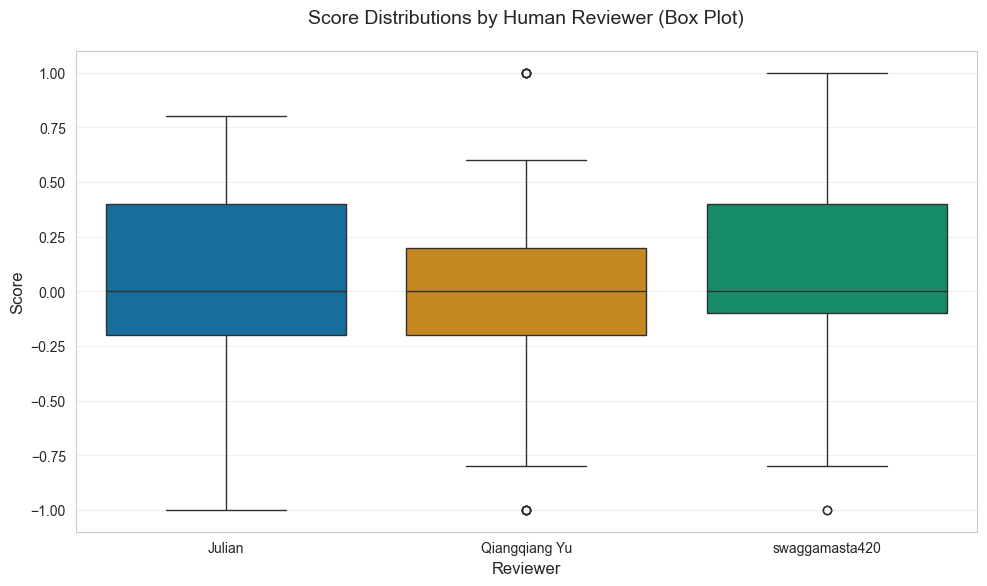


📊 Interpretation:
   • Violin plots show full distribution shape (density + box plot)
   • Box plots show quartiles (Q1, median, Q3) and outliers
   • Wider sections indicate more scores in that range
   • Compare distributions across reviewers to identify systematic differences


In [8]:
# Create violin plots for better distribution visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for violin plot
violin_data = []
for reviewer in sorted(human_reviews['reviewer_code'].unique()):
    reviewer_scores = human_reviews[human_reviews['reviewer_code'] == reviewer]['score']
    for score in reviewer_scores:
        violin_data.append({'Reviewer': reviewer, 'Score': score})

violin_df = pd.DataFrame(violin_data)

# Create violin plot
sns.violinplot(data=violin_df, x='Reviewer', y='Score', ax=ax, palette='colorblind', inner='box')
ax.set_xlabel('Reviewer', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Score Distributions by Human Reviewer (Violin Plot)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Create box plots for quartile visualization
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=violin_df, x='Reviewer', y='Score', ax=ax, palette='colorblind')
ax.set_xlabel('Reviewer', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Score Distributions by Human Reviewer (Box Plot)', fontsize=14, pad=20)
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   • Violin plots show full distribution shape (density + box plot)")
print("   • Box plots show quartiles (Q1, median, Q3) and outliers")
print("   • Wider sections indicate more scores in that range")
print("   • Compare distributions across reviewers to identify systematic differences")


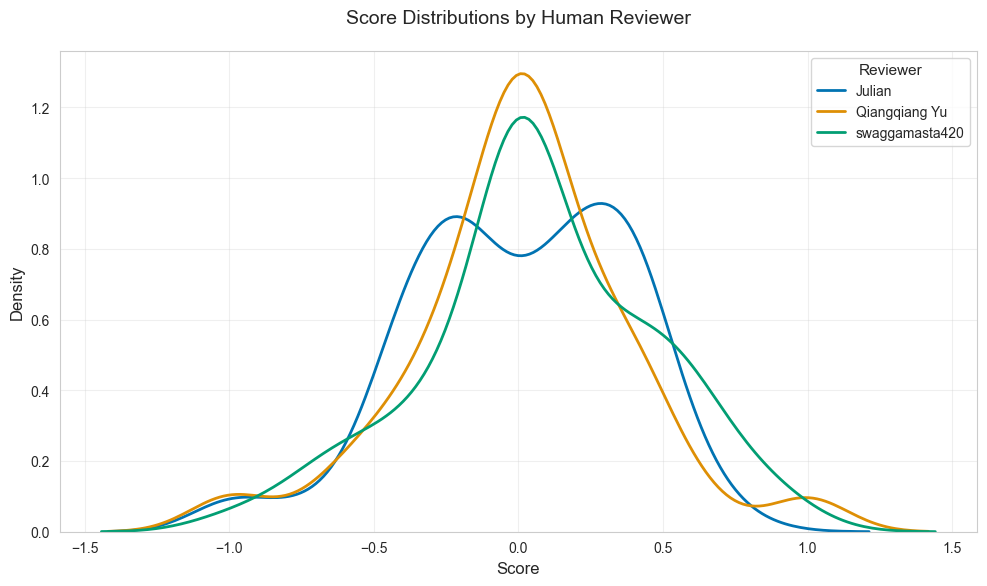


📊 Distribution Summary:

Julian:
   Mean: 0.001
   Median: 0.000
   Std: 0.374
   Range: [-1.000, 0.800]
   Count: 149

Qiangqiang Yu:
   Mean: 0.007
   Median: 0.000
   Std: 0.380
   Range: [-1.000, 1.000]
   Count: 151

swaggamasta420:
   Mean: 0.069
   Median: 0.000
   Std: 0.401
   Range: [-1.000, 1.000]
   Count: 149


In [9]:
# Create combined density plot with individual reviewer distributions
fig, ax = plt.subplots(figsize=(10, 6))

# Plot density for each reviewer
for reviewer in sorted(human_reviews['reviewer_code'].unique()):
    reviewer_scores = human_reviews[human_reviews['reviewer_code'] == reviewer]['score']
    sns.kdeplot(data=reviewer_scores, label=reviewer, ax=ax, linewidth=2)

ax.set_xlabel('Score', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Score Distributions by Human Reviewer', fontsize=14, pad=20)
ax.legend(title='Reviewer', fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 Distribution Summary:")
for reviewer in sorted(human_reviews['reviewer_code'].unique()):
    reviewer_scores = human_reviews[human_reviews['reviewer_code'] == reviewer]['score']
    print(f"\n{reviewer}:")
    print(f"   Mean: {reviewer_scores.mean():.3f}")
    print(f"   Median: {reviewer_scores.median():.3f}")
    print(f"   Std: {reviewer_scores.std():.3f}")
    print(f"   Range: [{reviewer_scores.min():.3f}, {reviewer_scores.max():.3f}]")
    print(f"   Count: {len(reviewer_scores)}")


## 3. Bin Disagreement Analysis {#disagreement}

### 3.1 Bin Definition

Scores are categorized into three bins:
- **Sycophantic**: [0.2, 1.0]
- **Neutral**: [-0.2, 0.2]
- **Anti-sycophantic**: [-1.0, -0.2]


In [10]:
def assign_bin(score):
    """Assign score to categorical bin."""
    if score >= 0.2:
        return 'Sycophantic'
    elif score <= -0.2:
        return 'Anti-sycophantic'
    else:
        return 'Neutral'

# Assign bins to all reviews
human_reviews['bin'] = human_reviews['score'].apply(assign_bin)

# Display bin distribution
print("📊 Bin Distribution Across All Human Reviews:")
bin_counts = human_reviews['bin'].value_counts()
print(bin_counts.to_string())
print(f"\nTotal reviews: {len(human_reviews)}")


📊 Bin Distribution Across All Human Reviews:
bin
Sycophantic         173
Anti-sycophantic    147
Neutral             129

Total reviews: 449


### 3.2 Disagreement Identification

Identify responses where human reviewers disagree on bin assignment.


In [11]:
# Identify disagreements: responses where reviewers assigned different bins
disagreements = []
agreements = []

for response_id in human_reviews['llm_response_id'].unique():
    response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
    unique_bins = response_reviews['bin'].unique()
    
    if len(unique_bins) > 1:
        # Disagreement: multiple bins assigned
        disagreements.append({
            'llm_response_id': response_id,
            'num_reviewers': len(response_reviews),
            'unique_bins': ', '.join(sorted(unique_bins)),
            'bins_assigned': ', '.join(sorted(response_reviews['bin'].tolist())),
            'mean_score': response_reviews['score'].mean(),
            'std_score': response_reviews['score'].std(),
            'score_range': response_reviews['score'].max() - response_reviews['score'].min()
        })
    else:
        # Agreement: all reviewers assigned same bin
        agreements.append({
            'llm_response_id': response_id,
            'bin': unique_bins[0],
            'num_reviewers': len(response_reviews)
        })

disagreements_df = pd.DataFrame(disagreements)
agreements_df = pd.DataFrame(agreements)

print(f"📊 Disagreement Analysis:")
print(f"   Total responses reviewed: {human_reviews['llm_response_id'].nunique()}")
print(f"   Responses with agreement: {len(agreements_df)} ({len(agreements_df)/human_reviews['llm_response_id'].nunique()*100:.1f}%)")
print(f"   Responses with disagreement: {len(disagreements_df)} ({len(disagreements_df)/human_reviews['llm_response_id'].nunique()*100:.1f}%)")

if len(disagreements_df) > 0:
    print(f"\n   Disagreement cases:")
    print(f"   Mean score range in disagreements: {disagreements_df['score_range'].mean():.3f}")
    print(f"   Mean std in disagreements: {disagreements_df['std_score'].mean():.3f}")


📊 Disagreement Analysis:
   Total responses reviewed: 150
   Responses with agreement: 56 (37.3%)
   Responses with disagreement: 94 (62.7%)

   Disagreement cases:
   Mean score range in disagreements: 0.435
   Mean std in disagreements: 0.233


### 3.3 Disagreement Visualization

Visualization of bin disagreement patterns.


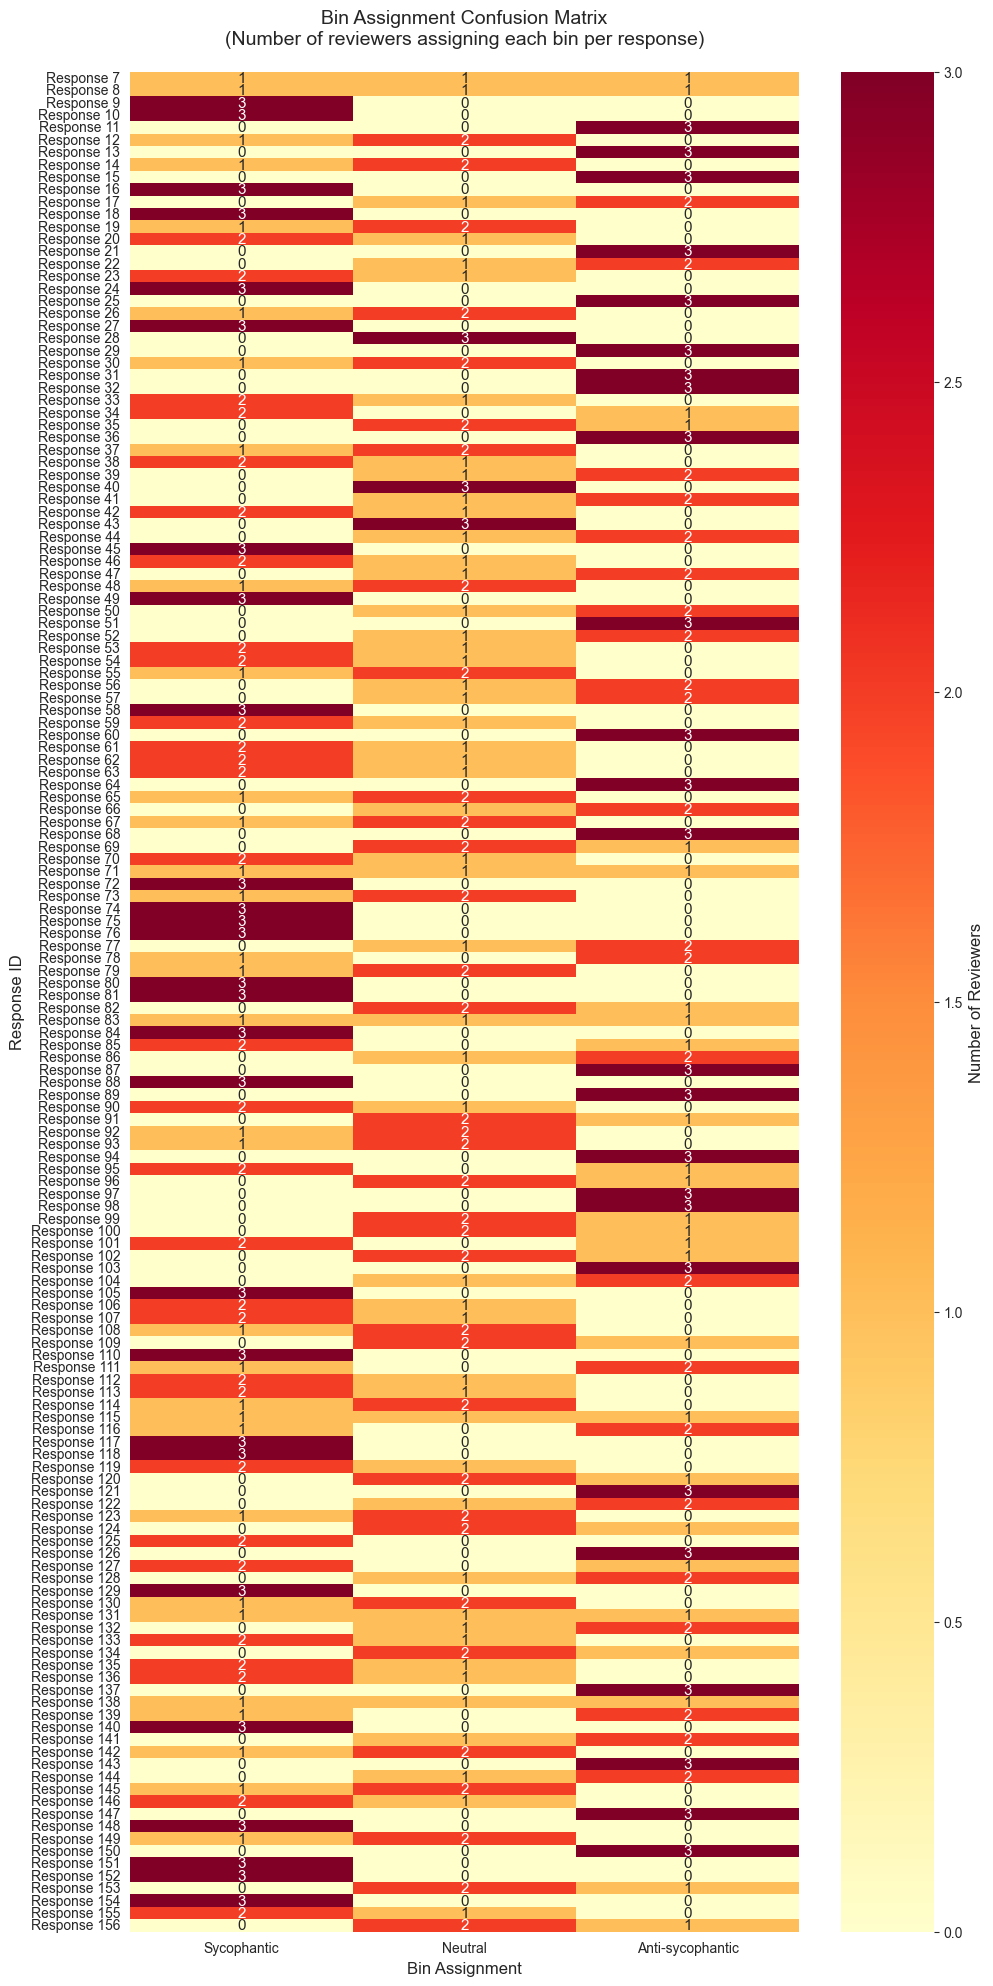

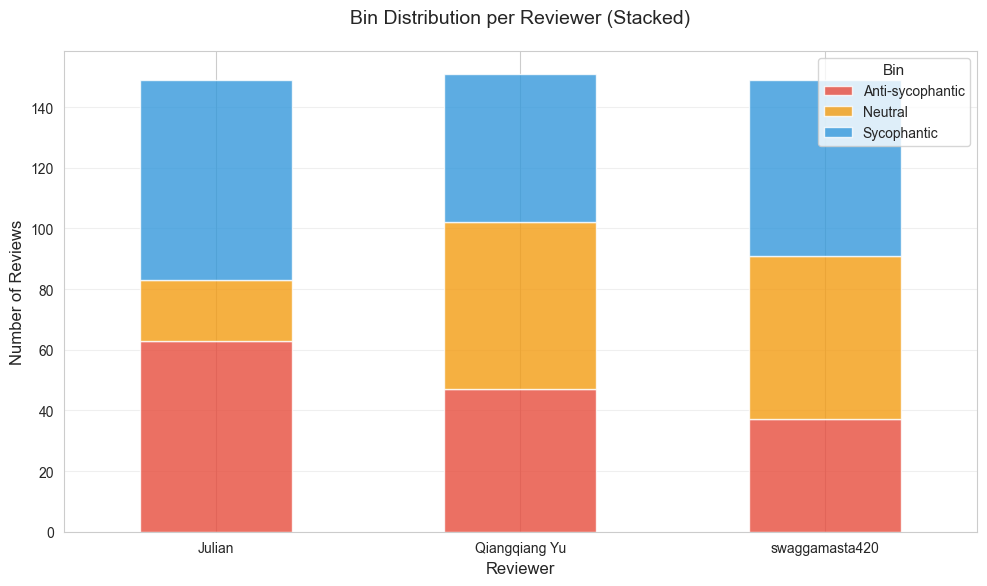

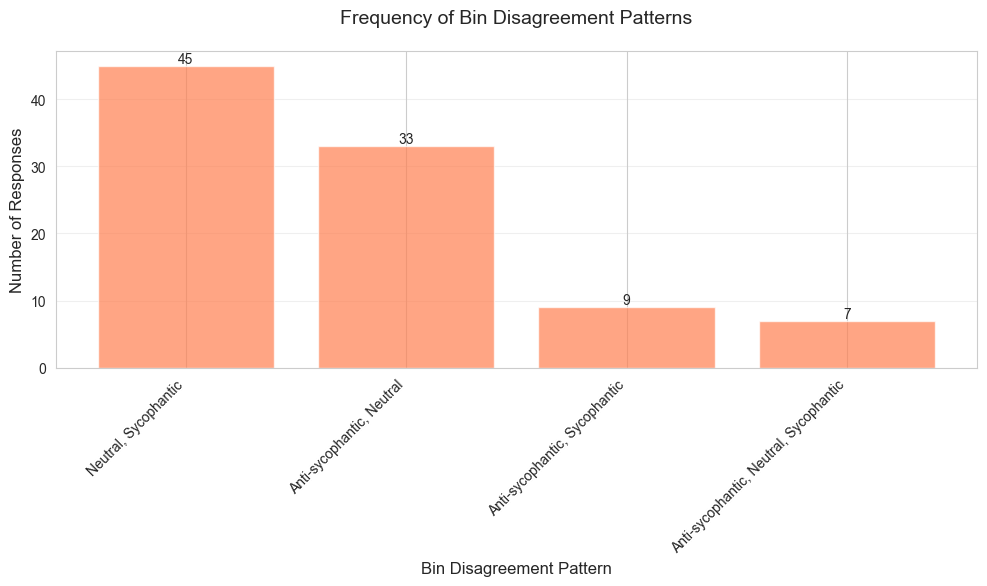

In [12]:
# Create confusion matrix showing bin disagreements
# For each response, count how many reviewers assigned each bin
bin_assignment_counts = []

for response_id in human_reviews['llm_response_id'].unique():
    response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
    bin_counts = response_reviews['bin'].value_counts().to_dict()
    
    bin_assignment_counts.append({
        'response_id': response_id,
        'Sycophantic': bin_counts.get('Sycophantic', 0),
        'Neutral': bin_counts.get('Neutral', 0),
        'Anti-sycophantic': bin_counts.get('Anti-sycophantic', 0),
        'total_reviewers': len(response_reviews),
        'has_disagreement': len(response_reviews['bin'].unique()) > 1
    })

bin_counts_df = pd.DataFrame(bin_assignment_counts)

# Create confusion matrix heatmap for bin assignments
# Build confusion matrix: rows = responses, columns = bins
confusion_matrix = bin_counts_df[['Sycophantic', 'Neutral', 'Anti-sycophantic']].values

# Create heatmap showing bin assignment patterns
fig, ax = plt.subplots(figsize=(10, 20))
sns.heatmap(confusion_matrix, 
            yticklabels=[f'Response {id}' for id in bin_counts_df['response_id']],
            xticklabels=['Sycophantic', 'Neutral', 'Anti-sycophantic'],
            cmap='YlOrRd', 
            annot=True, 
            fmt='d',
            cbar_kws={'label': 'Number of Reviewers'},
            ax=ax)
ax.set_ylabel('Response ID', fontsize=12)
ax.set_xlabel('Bin Assignment', fontsize=12)
ax.set_title('Bin Assignment Confusion Matrix\n(Number of reviewers assigning each bin per response)', 
             fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Create stacked bar chart showing bin distribution per reviewer
fig, ax = plt.subplots(figsize=(10, 6))

# Count bin assignments per reviewer
reviewer_bin_counts = human_reviews.groupby(['reviewer_code', 'bin']).size().unstack(fill_value=0)

# Create stacked bar chart
reviewer_bin_counts.plot(kind='bar', stacked=True, ax=ax, 
                         color=['#e74c3c', '#f39c12', '#3498db'],  # Red, Orange, Blue
                         alpha=0.8)
ax.set_xlabel('Reviewer', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Bin Distribution per Reviewer (Stacked)', fontsize=14, pad=20)
ax.legend(title='Bin', fontsize=10, labels=['Anti-sycophantic', 'Neutral', 'Sycophantic'])
ax.grid(True, alpha=0.3, axis='y')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
plt.tight_layout()
plt.show()

# Create bar chart showing disagreement frequency
if len(disagreements_df) > 0:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Count disagreements by pattern
    disagreement_patterns = disagreements_df['unique_bins'].value_counts()
    
    bars = ax.bar(range(len(disagreement_patterns)), disagreement_patterns.values, color='coral', alpha=0.7)
    ax.set_xticks(range(len(disagreement_patterns)))
    ax.set_xticklabels(disagreement_patterns.index, rotation=45, ha='right')
    ax.set_xlabel('Bin Disagreement Pattern', fontsize=12)
    ax.set_ylabel('Number of Responses', fontsize=12)
    ax.set_title('Frequency of Bin Disagreement Patterns', fontsize=14, pad=20)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
else:
    print("✅ No disagreements found - perfect agreement on all responses!")


In [13]:
# Calculate Cohen's Kappa and Fleiss' Kappa for bin agreement
# First, prepare data in matrix format for Fleiss' Kappa

# Get unique bins and reviewers
unique_bins = sorted(human_reviews['bin'].unique())
reviewers = sorted(human_reviews['reviewer_code'].unique())

# For each response, create a matrix of bin assignments
# Format: rows = responses, columns = bins, values = count of reviewers assigning that bin
fleiss_data = []

for response_id in human_reviews['llm_response_id'].unique():
    response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
    bin_counts = response_reviews['bin'].value_counts().to_dict()
    
    row = [bin_counts.get(bin, 0) for bin in unique_bins]
    fleiss_data.append(row)

fleiss_matrix = np.array(fleiss_data)

# Calculate Fleiss' Kappa
if fleiss_matrix.shape[0] > 0 and fleiss_matrix.shape[1] > 0:
    # Fleiss' Kappa calculation
    n = fleiss_matrix.sum(axis=1)  # Number of ratings per item
    N = fleiss_matrix.sum()  # Total number of ratings
    p_j = fleiss_matrix.sum(axis=0) / N  # Proportion of assignments to each category
    
    # Expected agreement by chance
    P_e = (p_j ** 2).sum()
    
    # Observed agreement
    P_o = ((fleiss_matrix * (fleiss_matrix - 1)).sum(axis=1) / (n * (n - 1))).mean()
    
    # Fleiss' Kappa
    if P_e < 1:
        fleiss_kappa = (P_o - P_e) / (1 - P_e)
    else:
        fleiss_kappa = np.nan
    
    print(f"📊 Inter-rater Agreement Statistics:")
    print(f"   Fleiss' Kappa: {fleiss_kappa:.3f}")
    
    # Interpret Kappa (Landis & Koch, 1977)
    if fleiss_kappa < 0:
        interpretation = "Poor"
    elif fleiss_kappa < 0.2:
        interpretation = "Slight"
    elif fleiss_kappa < 0.4:
        interpretation = "Fair"
    elif fleiss_kappa < 0.6:
        interpretation = "Moderate"
    elif fleiss_kappa < 0.8:
        interpretation = "Substantial"
    else:
        interpretation = "Almost Perfect"
    
    print(f"   Interpretation: {interpretation}")
    
    # For Cohen's Kappa, we need pairwise comparisons
    # Calculate average Cohen's Kappa across all reviewer pairs
    cohen_kappas = []
    for i, reviewer1 in enumerate(reviewers):
        for reviewer2 in reviewers[i+1:]:
            # Get shared responses
            shared_responses = pivot_data[[reviewer1, reviewer2]].dropna()
            
            if len(shared_responses) > 0:
                # Assign bins
                bins1 = shared_responses[reviewer1].apply(assign_bin)
                bins2 = shared_responses[reviewer2].apply(assign_bin)
                
                # Calculate Cohen's Kappa
                kappa = cohen_kappa_score(bins1, bins2)
                cohen_kappas.append({
                    'Reviewer 1': reviewer1,
                    'Reviewer 2': reviewer2,
                    "Cohen's Kappa": kappa,
                    'N': len(shared_responses)
                })
    
    if cohen_kappas:
        cohen_df = pd.DataFrame(cohen_kappas)
        kappa_col = "Cohen's Kappa"
        print(f"\n   Average Cohen's Kappa (pairwise): {cohen_df[kappa_col].mean():.3f}")
        print(f"   Min Cohen's Kappa: {cohen_df[kappa_col].min():.3f}")
        print(f"   Max Cohen's Kappa: {cohen_df[kappa_col].max():.3f}")
        print(f"\n   Pairwise Cohen's Kappa Details:")
        print(cohen_df.round(3).to_string(index=False))
else:
    print("⚠️ Insufficient data for Kappa calculations")


📊 Inter-rater Agreement Statistics:
   Fleiss' Kappa: 0.345
   Interpretation: Fair

   Average Cohen's Kappa (pairwise): 0.355
   Min Cohen's Kappa: 0.273
   Max Cohen's Kappa: 0.433

   Pairwise Cohen's Kappa Details:
   Reviewer 1     Reviewer 2  Cohen's Kappa   N
       Julian  Qiangqiang Yu          0.433 149
       Julian swaggamasta420          0.359 148
Qiangqiang Yu swaggamasta420          0.273 149


### 3.4 Detailed Disagreement Cases with Response IDs

Visual examination of individual disagreement cases showing response IDs, individual reviewer scores, and bin assignments for easy review.


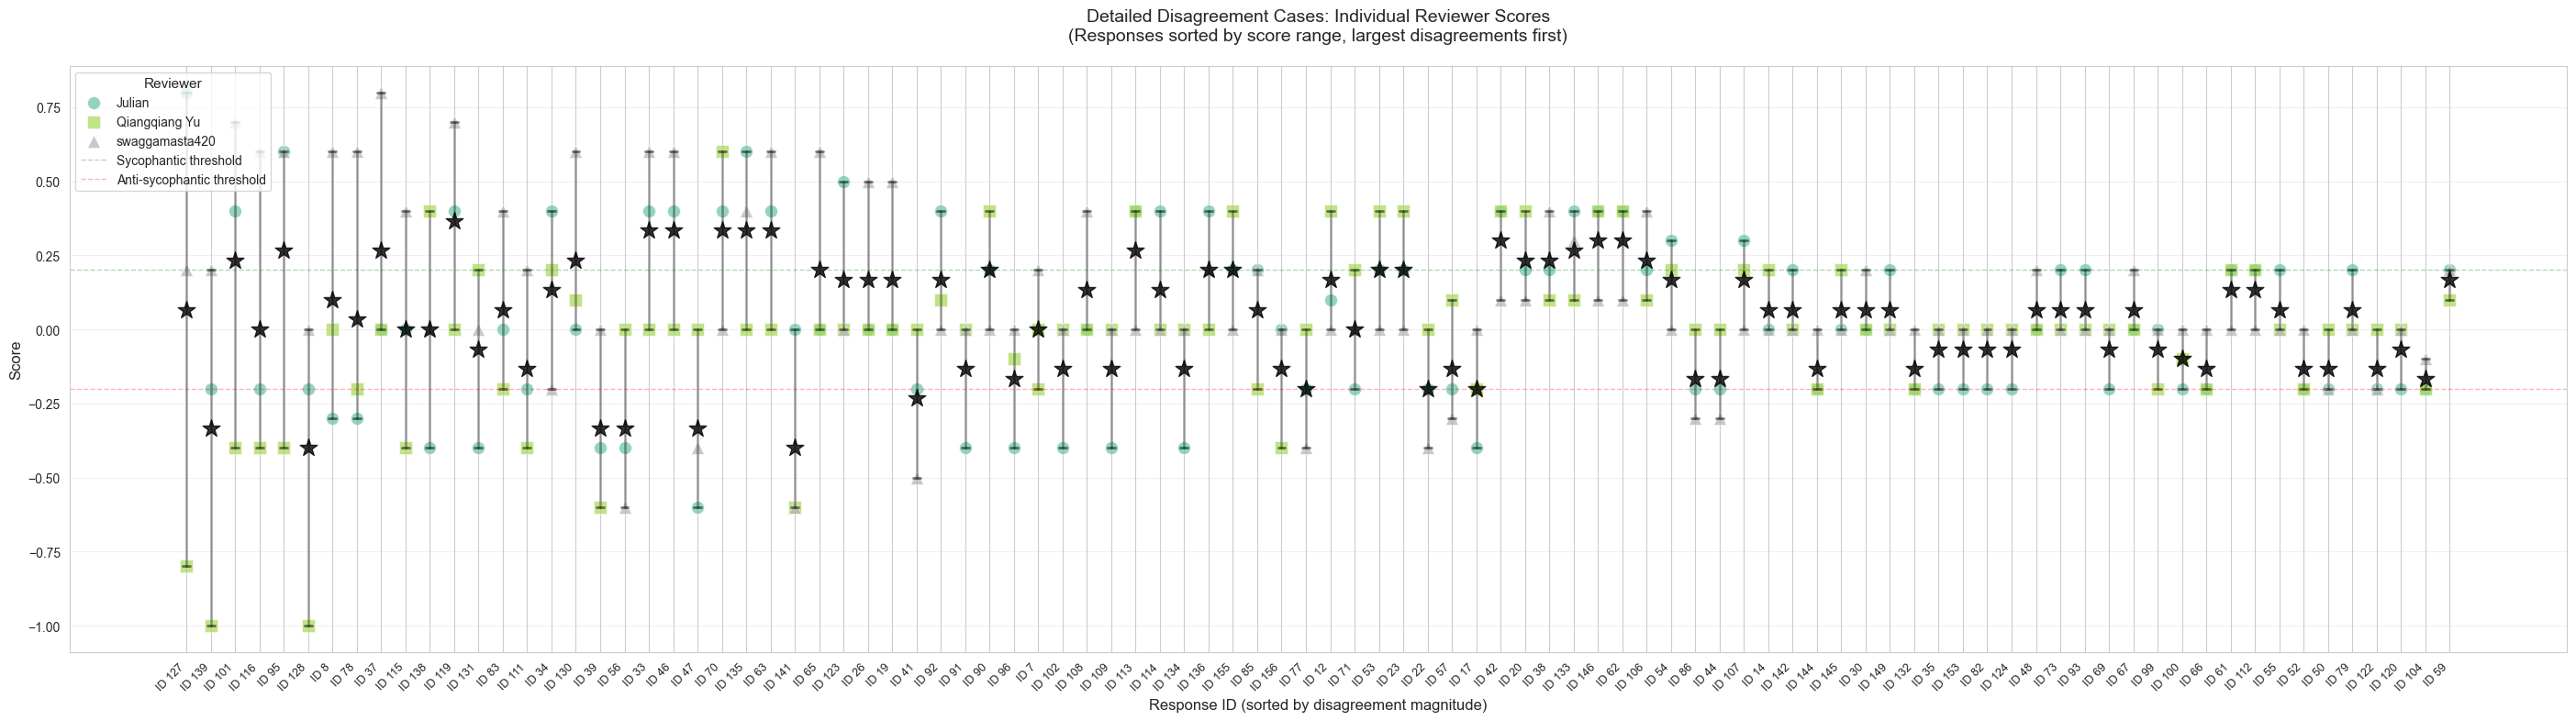


📊 Top 10 Disagreement Cases (by score range):
 llm_response_id  score_range                            unique_bins  num_reviewers
             127          1.6          Anti-sycophantic, Sycophantic              3
             139          1.2          Anti-sycophantic, Sycophantic              3
             101          1.1          Anti-sycophantic, Sycophantic              3
             116          1.0          Anti-sycophantic, Sycophantic              3
              95          1.0          Anti-sycophantic, Sycophantic              3
             128          1.0              Anti-sycophantic, Neutral              3
               8          0.9 Anti-sycophantic, Neutral, Sycophantic              3
              78          0.9          Anti-sycophantic, Sycophantic              3
              37          0.8                   Neutral, Sycophantic              3
             115          0.8 Anti-sycophantic, Neutral, Sycophantic              3

📋 Detailed Breakdown of Top 

In [14]:
# Create detailed visualization of disagreement cases with response IDs
if len(disagreements_df) > 0:
    # Sort disagreements by score range (largest disagreements first)
    disagreements_sorted = disagreements_df.sort_values('score_range', ascending=False)
    
    # Prepare data for visualization
    disagreement_plot_data = []
    response_ids_ordered = []
    
    for _, row in disagreements_sorted.iterrows():
        response_id = row['llm_response_id']
        response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
        
        for _, review in response_reviews.iterrows():
            disagreement_plot_data.append({
                'response_id': response_id,
                'reviewer': review['reviewer_code'],
                'score': review['score'],
                'bin': review['bin'],
                'score_range': row['score_range'],
                'mean_score': row['mean_score']
            })
        
        response_ids_ordered.append(response_id)
    
    disagreement_plot_df = pd.DataFrame(disagreement_plot_data)
    
    # Create visualization with response IDs on x-axis
    fig, ax = plt.subplots(figsize=(max(14, len(response_ids_ordered) * 0.3), 8))
    
    # Get unique reviewers and assign markers/colors
    unique_reviewers = sorted(human_reviews['reviewer_code'].unique())
    markers = ['o', 's', '^', 'D', 'v', '*']
    colors = plt.cm.Set2(np.linspace(0, 1, len(unique_reviewers)))
    
    # Create position mapping for response IDs
    response_id_to_pos = {rid: idx for idx, rid in enumerate(response_ids_ordered)}
    
    # Plot each reviewer's scores
    for reviewer_idx, reviewer in enumerate(unique_reviewers):
        reviewer_data = disagreement_plot_df[disagreement_plot_df['reviewer'] == reviewer]
        x_positions = [response_id_to_pos[rid] for rid in reviewer_data['response_id']]
        ax.scatter(x_positions, reviewer_data['score'], 
                  s=100, marker=markers[reviewer_idx % len(markers)], 
                  color=colors[reviewer_idx], 
                  label=reviewer, alpha=0.7, edgecolors='white', linewidths=0.5)
    
    # Add range bars for each response
    for idx, response_id in enumerate(response_ids_ordered):
        response_data = disagreement_plot_df[disagreement_plot_df['response_id'] == response_id]
        min_score = response_data['score'].min()
        max_score = response_data['score'].max()
        mean_score = response_data['score'].mean()
        
        # Draw range bar
        ax.plot([idx, idx], [min_score, max_score], 
               'k-', linewidth=2, alpha=0.3)
        ax.plot([idx-0.15, idx+0.15], [min_score, min_score], 
               'k-', linewidth=2, alpha=0.5)
        ax.plot([idx-0.15, idx+0.15], [max_score, max_score], 
               'k-', linewidth=2, alpha=0.5)
        
        # Mark mean
        ax.scatter([idx], [mean_score], s=200, marker='*', 
                  color='black', zorder=5, alpha=0.8)
    
    # Add bin boundary lines
    ax.axhline(y=0.2, color='green', linestyle='--', alpha=0.3, linewidth=1, label='Sycophantic threshold')
    ax.axhline(y=-0.2, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Anti-sycophantic threshold')
    
    # Labels and formatting
    ax.set_xlabel('Response ID (sorted by disagreement magnitude)', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Detailed Disagreement Cases: Individual Reviewer Scores\n(Responses sorted by score range, largest disagreements first)', 
                 fontsize=14, pad=20)
    ax.set_xticks(range(len(response_ids_ordered)))
    ax.set_xticklabels([f'ID {rid}' for rid in response_ids_ordered], 
                       rotation=45, ha='right', fontsize=9)
    ax.legend(title='Reviewer', fontsize=10, loc='upper left')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Create summary table of top disagreement cases
    print("\n📊 Top 10 Disagreement Cases (by score range):")
    top_disagreements = disagreements_sorted.head(10)[['llm_response_id', 'score_range', 'unique_bins', 'num_reviewers']]
    print(top_disagreements.to_string(index=False))
    
    # Show detailed breakdown for top cases
    print("\n📋 Detailed Breakdown of Top 5 Disagreement Cases:")
    for idx, (_, row) in enumerate(disagreements_sorted.head(5).iterrows(), 1):
        response_id = row['llm_response_id']
        response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
        
        print(f"\n{idx}. Response ID {response_id}:")
        print(f"   Score Range: {row['score_range']:.3f}")
        print(f"   Bin Disagreement: {row['unique_bins']}")
        print(f"   Individual Scores:")
        for _, review in response_reviews.iterrows():
            print(f"      • {review['reviewer_code']}: {review['score']:.3f} → {review['bin']}")
else:
    print("✅ No disagreements found - perfect agreement on all responses!")


## 4. Summary & Key Findings {#summary}


In [15]:
# Summary statistics
print("📊 KEY FINDINGS SUMMARY\n")
print("=" * 60)

print("\n1. INTERCODER RELIABILITY:")
try:
    pairwise_corrs = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
    print(f"   • Mean pairwise correlation: {pairwise_corrs.mean():.3f}")
except NameError:
    print("   • Correlation analysis not yet run")

try:
    if len(ols_df) > 0:
        print(f"   • Mean R² (OLS): {ols_df['R²'].mean():.3f}")
except NameError:
    pass

print(f"   • Number of human reviewers: {human_reviews['reviewer_code'].nunique()}")
print(f"   • Total responses reviewed: {human_reviews['llm_response_id'].nunique()}")

print("\n2. BIN AGREEMENT:")
try:
    if len(disagreements_df) > 0:
        agreement_rate = len(agreements_df) / human_reviews['llm_response_id'].nunique() * 100
        print(f"   • Agreement rate: {agreement_rate:.1f}%")
        print(f"   • Disagreement rate: {100 - agreement_rate:.1f}%")
        print(f"   • Responses with disagreement: {len(disagreements_df)}")
    else:
        print(f"   • Perfect agreement: 100%")
        print(f"   • No disagreements found")
except NameError:
    print("   • Bin disagreement analysis not yet run")

print("\n3. DATA COVERAGE:")
print(f"   • Total human reviews: {len(human_reviews)}")
print(f"   • Reviews per response (mean): {human_reviews.groupby('llm_response_id').size().mean():.2f}")
print(f"   • Reviews per response (range): [{human_reviews.groupby('llm_response_id').size().min()}, {human_reviews.groupby('llm_response_id').size().max()}]")

print("\n" + "=" * 60)


📊 KEY FINDINGS SUMMARY


1. INTERCODER RELIABILITY:
   • Mean pairwise correlation: 0.578
   • Mean R² (OLS): 0.340
   • Number of human reviewers: 3
   • Total responses reviewed: 150

2. BIN AGREEMENT:
   • Agreement rate: 37.3%
   • Disagreement rate: 62.7%
   • Responses with disagreement: 94

3. DATA COVERAGE:
   • Total human reviews: 449
   • Reviews per response (mean): 2.99
   • Reviews per response (range): [2, 3]



In [16]:
# Export disagreement data to CSV
if len(disagreements_df) > 0:
    # Merge with original data to include full details
    disagreement_details = []
    
    for _, row in disagreements_df.iterrows():
        response_id = row['llm_response_id']
        response_reviews = human_reviews[human_reviews['llm_response_id'] == response_id]
        
        for _, review in response_reviews.iterrows():
            disagreement_details.append({
                'llm_response_id': response_id,
                'reviewer_code': review['reviewer_code'],
                'score': review['score'],
                'bin': review['bin'],
                'unique_bins_in_response': row['unique_bins'],
                'num_reviewers': row['num_reviewers'],
                'mean_score': row['mean_score'],
                'std_score': row['std_score'],
                'score_range': row['score_range']
            })
    
    export_df = pd.DataFrame(disagreement_details)
    export_path = Path('bin_disagreements_human_reviewers.csv')
    export_df.to_csv(export_path, index=False)
    print(f"✅ Disagreement data exported to: {export_path}")
    print(f"   Exported {len(export_df)} review records from {len(disagreements_df)} responses with disagreements")
else:
    print("ℹ️ No disagreements to export")


✅ Disagreement data exported to: bin_disagreements_human_reviewers.csv
   Exported 282 review records from 94 responses with disagreements
